# prediction on Singapore housing price with linear regression models

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import utils.preprocess as preprocessor


In [2]:
# reload external python modules; automatically
%load_ext autoreload
%autoreload 2

In [18]:
# data source
train_data_file = './data/train.csv'
test_data_file = './data/test.csv'


In [19]:
df_train = pd.read_csv(train_data_file)
df_test = pd.read_csv(test_data_file)


In [5]:
df_train.head(3)

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,...,unspecified,NaN,116.0,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575,...,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070,...,partial,"studio, 3, 4, 5, 6 br",56.0,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0


In [6]:
df_test.head(3)

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area
0,777912,1 bed condo for sale in the gazania,17 how sun drive,the gazania,condo,freehold,2022.0,1.0,1.0,463,NaN,unfurnished,"studio, 1, 2, 3, 4, 5 br",250.0,https://www.99.co/singapore/condos-apartments/...,1.344334,103.878690,0,upper paya lebar,serangoon
1,936612,3 bed condo for sale in vue 8 residence,95 pasir ris heights,vue 8 residence,Condo,99-year leasehold,2017.0,3.0,3.0,1033,high,unspecified,"studio, 1, 2, 3, 4, 5 br",463.0,https://www.99.co/singapore/condos-apartments/...,1.380281,103.943878,0,pasir ris west,pasir ris
2,995264,1 bed condo for sale in icon,10 gopeng street,icon,condo,99-year leasehold,2007.0,1.0,1.0,570,NaN,fully,"studio, 1, 2, 3 br",646.0,https://www.99.co/singapore/condos-apartments/...,1.294668,103.850074,0,bras basah,museum


### data preprocessing to process outliers and missing values

In [20]:
# preprocessing training data
# lat and lng
preprocessor.fix_abnormal_geo_location(df_train)
# subzone
preprocessor.map_subzone_by_geo_location_knn(df_train)
# tenure & built_year
preprocessor.universalize_tenure(df_train)
preprocessor.normalize_tenure(df_train)
preprocessor.fillna_by_grouping(df_train, 'tenure', 'property_name')
preprocessor.fillna_by_grouping(df_train, 'built_year', 'property_name')
preprocessor.handle_years_and_tenure_nan(df_train, 'tenure')
preprocessor.handle_years_and_tenure_nan(df_train, 'built_year')
# num_beds and baths
preprocessor.process_num_beds_and_baths(df_train)
# property_type
preprocessor.process_property_type(df_train)
# size_sqft
preprocessor.df_process_size_sqft(df_train)
# price
preprocessor.df_process_price(df_train)

#### tenure still has a nan value after processing

99          13040
freehold     6737
999           476
Name: tenure, dtype: int64
na number of tenure column is 1
2023.0    2244
2025.0    1612
2024.0    1554
2017.0    1223
2022.0    1212
          ... 
1991.0      37
1971.0      34
2028.0      31
1963.0       9
1968.0       6
Name: built_year, Length: 63, dtype: int64
na number of built_year column is 0


In [21]:
# preprocessing testing data
# lat and lng
preprocessor.fix_abnormal_geo_location(df_test)
# subzone
preprocessor.map_subzone_by_geo_location_knn(df_test)
# tenure & built_year
preprocessor.universalize_tenure(df_test)
preprocessor.normalize_tenure(df_test)
preprocessor.fillna_by_grouping(df_test, 'tenure', 'property_name')
preprocessor.fillna_by_grouping(df_test, 'built_year', 'property_name')
preprocessor.handle_years_and_tenure_nan(df_test, 'tenure')
preprocessor.handle_years_and_tenure_nan(df_test, 'built_year')
# num_beds and baths
preprocessor.process_num_beds_and_baths(df_test)
# property_type
preprocessor.process_property_type(df_test)
# sizeq_sqft
preprocessor.df_process_size_sqft(df_test)


99          4444
freehold    2339
999          183
Name: tenure, dtype: int64
na number of tenure column is 0
2023.0    775
2024.0    529
2025.0    506
2017.0    426
2026.0    424
         ... 
1967.0     12
2028.0     11
1971.0      8
1968.0      7
1963.0      3
Name: built_year, Length: 63, dtype: int64
na number of built_year column is 0


In [22]:
drop_columns = [
    "listing_id", 
    "title", 
    "address", 
    "property_name",
    "floor_level", 
    "elevation", 
    "planning_area", 
    "available_unit_types", 
    "total_num_units", 
    "furnishing", 
    "available_unit_types", 
    "property_details_url"
]

df_train.drop(columns=drop_columns, inplace=True)
df_test.drop(columns=drop_columns, inplace=True)


In [10]:
df_train.head(3)

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,subzone,price
51,condo,freehold,2025.0,4.0,3.0,1313.0,1.313628,103.883109,aljunied,2274800.0
1609,condo,freehold,2025.0,4.0,3.0,1302.0,1.313628,103.883109,aljunied,2100000.0
6882,condo,freehold,2025.0,4.0,3.0,1302.0,1.313628,103.883109,aljunied,2100000.0


In [11]:
df_test.head(3)

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,subzone
118,condo,freehold,2025.0,4.0,3.0,1195.0,1.313628,103.883109,aljunied
3651,condo,freehold,2025.0,3.0,3.0,1023.0,1.313628,103.883109,aljunied
3378,condo,freehold,2025.0,3.0,2.0,1023.0,1.313628,103.883109,aljunied


# train models

### split train and test data

In [23]:
# drop tenure == nan
df_train = df_train.drop(index=0)

In [24]:
# get all object and float attributes
object_atts = df_train.select_dtypes('object').columns.to_list()
object_atts.remove('property_type')
float_atts = df_train.select_dtypes('float').columns.to_list()


In [31]:
# encoding object attributes first and then calculate sqft_price after splitting train_test_data

# df_train_encoding = pd.get_dummies(df_train[object_atts])
# df_train_encoding[float_atts] = df_train[float_atts]
# df_train_encoding['property_type'] = df_train['property_type']


In [35]:
# df_train_encoding, df_test_encoding = train_test_split(df_train_encoding, test_size = 0.1, random_state = 42)

df_train_9, df_test_1 = train_test_split(df_train, test_size = 0.1, random_state = 42)


In [38]:
# encoding for train data
df_train_encoding = pd.get_dummies(df_train_9[['tenure']])
df_train_encoding[float_atts] = df_train_9[float_atts]
df_train_encoding['property_type'] = df_train_9['property_type']
df_train_encoding['subzone'] = df_train_9['subzone']

# encoding for property_type
sqft_price_train = df_train_encoding.groupby(['property_type'])['price'].sum() / df_train_encoding.groupby(['property_type'])['size_sqft'].sum()
sqft_price_train = sqft_price_train.to_frame(name='sqft_price')

df_train_encoding = df_train_encoding.join(sqft_price_train, on='property_type')


# encoding for subzone
sqft_subzone_train = df_train_encoding.groupby(['subzone'])['price'].sum() / df_train_encoding.groupby(['subzone'])['size_sqft'].sum()
sqft_subzone_train = sqft_subzone_train.to_frame(name='sqft_subzone')

df_train_encoding = df_train_encoding.join(sqft_subzone_train, on='subzone')



# encoding for subzone and property_type
sqft_subzone_type_train = df_train_encoding.groupby(['subzone', 'property_type'])['price'].sum() / df_train_encoding.groupby(['subzone', 'property_type'])['size_sqft'].sum()
sqft_subzone_type_train = sqft_subzone_type_train.to_frame(name='sqft_subzone_type')

df_train_encoding = df_train_encoding.join(sqft_subzone_type_train, on=['subzone','property_type'])


df_train_encoding = df_train_encoding.drop(['property_type'], axis=1)
df_train_encoding = df_train_encoding.drop(['subzone'], axis=1)



In [39]:
# encoding for test data
df_test_encoding = pd.get_dummies(df_test_1[['tenure']])
df_test_encoding[float_atts] = df_test_1[float_atts]
df_test_encoding['property_type'] = df_test_1['property_type']
df_test_encoding['subzone'] = df_test_1['subzone']

# encoding for property_type
sqft_price_test = df_test_encoding.groupby(['property_type'])['price'].sum() / df_test_encoding.groupby(['property_type'])['size_sqft'].sum()
sqft_price_test = sqft_price_test.to_frame(name='sqft_price')

df_test_encoding = df_test_encoding.join(sqft_price_test, on='property_type')


# encoding for subzone
sqft_subzone_test = df_test_encoding.groupby(['subzone'])['price'].sum() / df_test_encoding.groupby(['subzone'])['size_sqft'].sum()
sqft_subzone_test = sqft_subzone_test.to_frame(name='sqft_subzone')

df_test_encoding = df_test_encoding.join(sqft_subzone_test, on='subzone')


# encoding for subzone and property_type
sqft_subzone_type_test = df_test_encoding.groupby(['subzone', 'property_type'])['price'].sum() / df_test_encoding.groupby(['subzone', 'property_type'])['size_sqft'].sum()
sqft_subzone_type_test = sqft_subzone_type_test.to_frame(name='sqft_subzone_type')

df_test_encoding = df_test_encoding.join(sqft_subzone_type_test, on=['subzone','property_type'])


df_test_encoding = df_test_encoding.drop(['property_type'], axis=1)
df_test_encoding = df_test_encoding.drop(['subzone'], axis=1)


In [40]:
# split attributes and predict
all_X_att_train = df_train_encoding.columns.to_list()
all_X_att_train.remove('price')
all_X_att_test = df_test_encoding.columns.to_list()
all_X_att_test.remove('price')
X_train, X_test, y_train, y_test = df_train_encoding[all_X_att_train], df_test_encoding[all_X_att_test], df_train_encoding['price'], df_test_encoding['price']


In [95]:
df_train['property_type'].unique()

array(['condo', 'apartment', 'hdb', 'terraced house', 'corner terrace',
       'semi-detached house', 'executive condo', 'bungalow',
       'cluster house', 'landed', 'good class bungalow', 'walk-up',
       'townhouse', 'land only', 'conservation house', 'shophouse'],
      dtype=object)

In [93]:
X_train

,tenure_99,tenure_999,tenure_freehold,built_year,num_beds,num_baths,size_sqft,lat,lng,sqft_price,sqft_subzone,sqft_subzone_type
17107,1,0,0,2023.0,3.0,2.0,947.0,1.304855,103.773776,2558.257118,1972.070638,2149.816294
7820,1,0,0,1982.0,3.0,2.0,979.0,1.318843,103.886524,1302.578439,1269.877946,663.837708
4604,1,0,0,1992.0,4.0,2.0,1550.0,1.368459,103.953651,1302.578439,1181.698040,615.715291
7902,0,0,1,1978.0,6.0,4.0,2669.0,1.319009,103.778489,2558.257118,2085.946788,1562.621574
2535,1,0,0,2016.0,2.0,1.0,624.0,1.365332,103.771484,2558.257118,1411.354720,1566.096465
...,...,...,...,...,...,...,...,...,...,...,...,...
10367,0,0,1,2025.0,2.0,2.0,829.0,1.310184,103.835914,2558.257118,4186.231664,4194.587257
10742,1,0,0,1993.0,3.0,2.0,1700.0,1.336077,103.735642,2558.257118,561.340118,1235.294118
7788,1,0,0,2016.0,4.0,3.0,1271.0,1.376468,103.958384,1253.564416,1073.827128,1201.333747
11132,0,0,1,2024.0,3.0,3.0,1152.0,1.326012,103.850063,2558.257118,1444.775732,2018.038371


### train linear regression model

In [41]:
regressor = LinearRegression()
regressor.fit(
    X=X_train,
    y=y_train,
)
y_hat_train = regressor.predict(X_train)
y_hat_test = regressor.predict(X_test)

### evaluate linear regression model

In [42]:
# calculate MAE, MSE, RMSE for train_data
print('train_MAE: ', metrics.mean_absolute_error(y_hat_train, y_train))
print('train_MSE: ', metrics.mean_squared_error(y_hat_train, y_train))
print('train_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_train, y_train)))
print('score_train: ', regressor.score(X_train, y_train))

# calculate MAE, MSE, RMSE for test_data
print('test_MAE: ', metrics.mean_absolute_error(y_hat_test, y_test))
print('test_MSE: ', metrics.mean_squared_error(y_hat_test, y_test))
print('test_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_test, y_test)))
print('score_test: ', regressor.score(X_test, y_test))


train_MAE:  3243682.6575733684
train_MSE:  847784135951626.4
train_RMSE:  29116732.92029218
score_train:  0.04298367923191171
test_MAE:  2766582.7689078064
test_MSE:  18072868289759.78
test_RMSE:  4251219.623797362
score_test:  0.08201127242747108


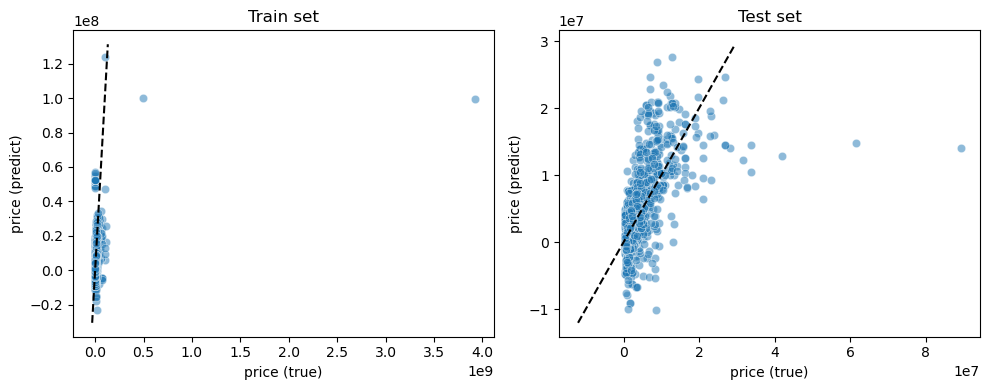

In [89]:
outputs = 'price'
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train.ravel(),
    y=y_hat_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test.ravel(),
    y=y_hat_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.plot(a.get_ylim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

### train kernel ridge regression model

In [44]:
kernel_model = KernelRidge(alpha=1.0, kernel='linear')
kernel_model.fit(X_train, y_train)
y_hat_train_linear = kernel_model.predict(X_train)
y_hat_test_linear = kernel_model.predict(X_test)

### evaluate kernel ridge regression model

In [45]:
# calculate MAE, MSE, RMSE for train_data
print('train_MAE: ', metrics.mean_absolute_error(y_hat_train_linear, y_train))
print('train_MSE: ', metrics.mean_squared_error(y_hat_train_linear, y_train))
print('train_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_train_linear, y_train)))
print('score_train: ', regressor.score(X_train, y_train))

# calculate MAE, MSE, RMSE for test_data
print('test_MAE: ', metrics.mean_absolute_error(y_hat_test_linear, y_test))
print('test_MSE: ', metrics.mean_squared_error(y_hat_test_linear, y_test))
print('test_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_test_linear, y_test)))
print('score_test: ', regressor.score(X_test, y_test))


train_MAE:  3238749.1420379356
train_MSE:  847853071601187.6
train_RMSE:  29117916.67687075
score_train:  0.04298367923191171
test_MAE:  2743667.6805555555
test_MSE:  18029697623947.63
test_RMSE:  4246139.143262692
score_test:  0.08201127242747108


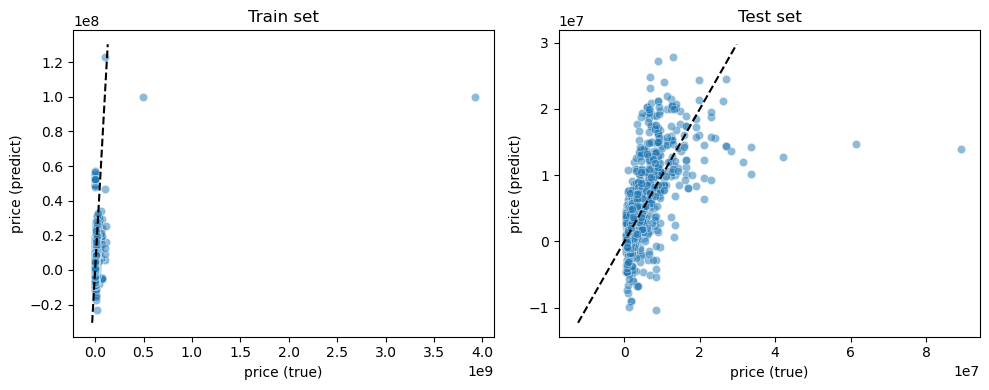

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train.ravel(),
    y=y_hat_train_linear,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test.ravel(),
    y=y_hat_test_linear,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.plot(a.get_ylim(), a.get_ylim(), ls='--', c='k')

ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

### train polynomial kernel regression model

In [47]:
kernel_model = KernelRidge(alpha=1.0, kernel='polynomial', degree=3)
kernel_model.fit(X_train, y_train)
y_hat_train_polynomial = kernel_model.predict(X_train)
y_hat_test_polynomial = kernel_model.predict(X_test)

### evaluate polynomial kernel regression model

In [48]:
# calculate MAE, MSE, RMSE for train_data
print('train_MAE: ', metrics.mean_absolute_error(y_hat_train_polynomial, y_train))
print('train_MSE: ', metrics.mean_squared_error(y_hat_train_polynomial, y_train))
print('train_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_train_polynomial, y_train)))
print('score_train: ', regressor.score(X_train, y_train))

# calculate MAE, MSE, RMSE for test_data
print('test_MAE: ', metrics.mean_absolute_error(y_hat_test_polynomial, y_test))
print('test_MSE: ', metrics.mean_squared_error(y_hat_test_polynomial, y_test))
print('test_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_test_polynomial, y_test)))
print('score_test: ', regressor.score(X_test, y_test))


train_MAE:  6589513.372243052
train_MSE:  271072090392621.4
train_RMSE:  16464267.077298686
score_train:  0.04298367923191171
test_MAE:  16907153.45436508
test_MSE:  1373154473967572.5
test_RMSE:  37056099.01173587
score_test:  0.08201127242747108


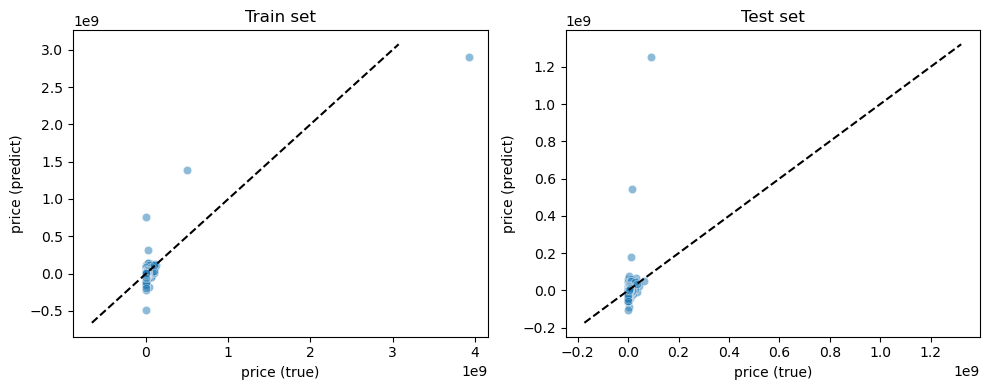

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train.ravel(),
    y=y_hat_train_polynomial,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test.ravel(),
    y=y_hat_test_polynomial,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.plot(a.get_ylim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

### train RBF kernel regression model

In [80]:
kernel_model = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.08)
kernel_model.fit(X_train, y_train)
y_hat_train_rbf = kernel_model.predict(X_train)
y_hat_test_rbf = kernel_model.predict(X_test)

### evaluate RBF kernel regression model

In [81]:
# calculate MAE, MSE, RMSE for train_data
print('train_MAE: ', metrics.mean_absolute_error(y_hat_train_rbf, y_train))
print('train_MSE: ', metrics.mean_squared_error(y_hat_train_rbf, y_train))
print('train_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_train_rbf, y_train)))
print('score_train: ', regressor.score(X_train, y_train))

# calculate MAE, MSE, RMSE for test_data
print('test_MAE: ', metrics.mean_absolute_error(y_hat_test_rbf, y_test))
print('test_MSE: ', metrics.mean_squared_error(y_hat_test_rbf, y_test))
print('test_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_test_rbf, y_test)))
print('score_test: ', regressor.score(X_test, y_test))


train_MAE:  945024.2852618064
train_MSE:  220778387909621.78
train_RMSE:  14858613.256613882
score_train:  0.04298367923191171
test_MAE:  3050056.39871806
test_MSE:  28990306143666.348
test_RMSE:  5384264.679941575
score_test:  0.08201127242747108


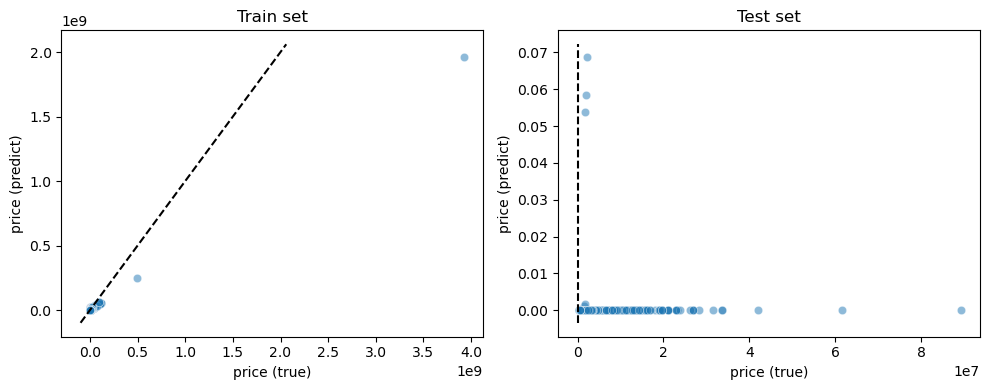

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train.ravel(),
    y=y_hat_train_rbf,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test.ravel(),
    y=y_hat_test_rbf,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.plot(a.get_ylim(), a.get_ylim(), ls='--', c='k')

ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

### Standardize RBF attributes

In [73]:
normalized_data = preprocessing.StandardScaler()
train_rbf = pd.DataFrame(normalized_data.fit_transform(df_train_encoding), index=df_train_encoding.index,columns=df_train_encoding.columns)
test_rbf = pd.DataFrame(normalized_data.fit_transform(df_test_encoding), index=df_test_encoding.index,columns=df_test_encoding.columns)

all_att = df_train_encoding.columns.to_list()
all_att.remove('price')
X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = train_rbf[all_att], test_rbf[all_att], train_rbf['price'], test_rbf['price']


### train RBF model with standardized data

In [90]:
kernel_model = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.2)
kernel_model.fit(X_train_rbf, y_train_rbf)
y_hat_train_rbf = kernel_model.predict(X_train_rbf)
y_hat_test_rbf = kernel_model.predict(X_test_rbf)

In [91]:
# calculate MAE, MSE, RMSE for train_data
print('train_MAE: ', metrics.mean_absolute_error(y_hat_train_rbf, y_train_rbf))
print('train_MSE: ', metrics.mean_squared_error(y_hat_train_rbf, y_train_rbf))
print('train_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_train_rbf, y_train_rbf)))
print('score_train: ', regressor.score(X_train_rbf, y_train_rbf))

# calculate MAE, MSE, RMSE for test_data
print('test_MAE: ', metrics.mean_absolute_error(y_hat_test_rbf, y_test_rbf))
print('test_MSE: ', metrics.mean_squared_error(y_hat_test_rbf, y_test_rbf))
print('test_RMSE: ', np.sqrt(metrics.mean_squared_error(y_hat_test_rbf, y_test_rbf)))
print('score_test: ', regressor.score(X_test_rbf, y_test_rbf))


train_MAE:  0.021348078832302775
train_MSE:  0.4244823397925303
train_RMSE:  0.6515230922941491
score_train:  -2.5989467670155498e+17
test_MAE:  0.4472797123347698
test_MSE:  0.770641303341465
test_RMSE:  0.8778617791779438
score_test:  -2.598954436596063e+17


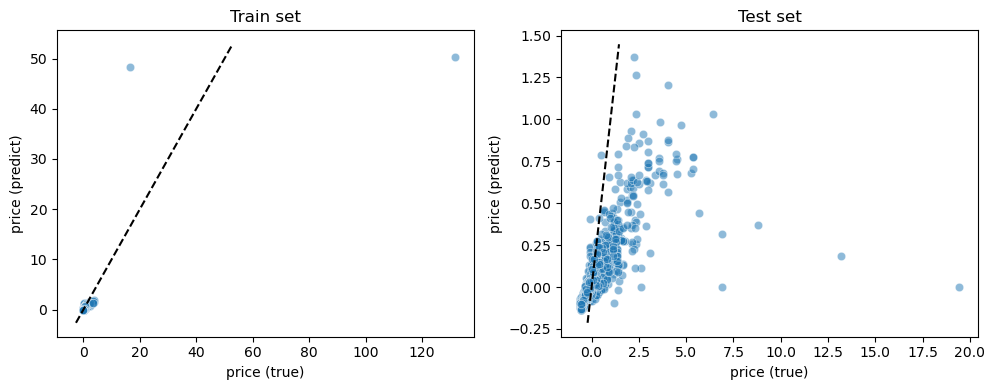

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train_rbf.ravel(),
    y=y_hat_train_rbf,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test_rbf.ravel(),
    y=y_hat_test_rbf,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel(f'{outputs} (true)')
    a.set_ylabel(f'{outputs} (predict)')
    a.plot(a.get_ylim(), a.get_ylim(), ls='--', c='k')

ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()